## [골빈해커 - Word2Vec](https://github.com/golbin/TensorFlow-Tutorials/blob/master/04%20-%20Neural%20Network%20Basic/03%20-%20Word2Vec.py)

In [174]:
%matplotlib inline

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
tf.reset_default_graph()
# matplot에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/H2GTRE.ttf").get_name()
matplotlib.rc('font', family = font_name)

sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]

# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유 단어로 리스트를 만듬
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))

word_dict = {w: i for i,w in enumerate(word_list)}
print(word_dict)


{'동물': 0, '생선': 1, '게임': 2, '강아지': 3, '영화': 4, '나': 5, '애니': 6, '고양이': 7, '좋다': 8, '우유': 9, '음악': 10, '여자친구': 11, '눈': 12, '책': 13, '만화': 14, '싫다': 15}


### target , context 쌍의 단어 gram(window 사이즈에 따라)
- 단어는 index값으로 바꿔줌


In [176]:
# 윈도우 사이즈를 1로 하는 skip-gram
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # 단어에 해당하는 index를 target에
    target = word_dict[word_sequence[i]]
    # 앞뒤의 단어들에 해당하는 index를 context에
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    
    for w in context:
        skip_grams.append([target, w])
print(skip_grams)

[[7, 5], [7, 8], [8, 7], [8, 5], [5, 8], [5, 3], [3, 5], [3, 8], [8, 3], [8, 5], [5, 8], [5, 0], [0, 5], [0, 8], [8, 0], [8, 3], [3, 8], [3, 7], [7, 3], [7, 0], [0, 7], [0, 11], [11, 0], [11, 7], [7, 11], [7, 3], [3, 7], [3, 8], [8, 3], [8, 7], [7, 8], [7, 1], [1, 7], [1, 9], [9, 1], [9, 8], [8, 9], [8, 3], [3, 8], [3, 1], [1, 3], [1, 15], [15, 1], [15, 9], [9, 15], [9, 8], [8, 9], [8, 3], [3, 8], [3, 7], [7, 3], [7, 12], [12, 7], [12, 8], [8, 12], [8, 5], [5, 8], [5, 11], [11, 5], [11, 8], [8, 11], [8, 11], [11, 8], [11, 5], [5, 11], [5, 15], [15, 5], [15, 11], [11, 15], [11, 5], [5, 11], [5, 4], [4, 5], [4, 13], [13, 4], [13, 10], [10, 13], [10, 8], [8, 10], [8, 5], [5, 8], [5, 2], [2, 5], [2, 14], [14, 2], [14, 6], [6, 14], [6, 8], [8, 6], [8, 7], [7, 8], [7, 3], [3, 7], [3, 15], [15, 3], [15, 3], [3, 15], [3, 7], [7, 3], [7, 8]]


In [183]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성        
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace = False)
    
    for i in random_index:
        random_inputs.append(data[i][0]) # target
        random_labels.append([data[i][1]]) # context word
    
    return random_inputs, random_labels

# 옵션
training_epoch = 300
learning_rate = 0.1
batch_size = 20
# 단어 벡터 구성하는 embedding 차원 크기
embedding_size = 2
# 샘플링 크기 (배치 사이즈보다 작아야 함)
num_sampled = 15
# 총 단어 갯수 - 16
voc_size = len(word_list)

# 신경망 모델 구성
# (20, )
X = tf.placeholder(tf.int32, shape = [batch_size], name="input")
# (20, 1)
Y = tf.placeholder(tf.int32, shape = [batch_size, 1], name="output")
# (16, 2)
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# (20, 2)
# embeddings에서 input 해당하는 index들을 look up해줌
selected_embed = tf.nn.embedding_lookup(embeddings, X)
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]


# negative sampling - word2vec의 학습 연산량을 줄여주기 위한 학습 알고리즘
# 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)을 적당히 뽑고(5~20개)
# 이를 정답단어와 합쳐 전체 단어처럼 softmax의 확률을 구함
# 이렇게 함으로써 전체 one-hot vector크기의 가중치를 수정할 필요가 없음(연산량을 크게 줄일 수 있음)
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수는 tensroflow에서 지원
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, Y, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# 학습

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(training_epoch):
        # batch size만큼 skip_gram에서 랜덤하게 뽑아옴
        # 굳이 이렇게 하지 않아도 됨 100개밖에 안되는 데이터들임
        # batch_size 는 20
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss], feed_dict={X:batch_inputs, Y:batch_labels})

        if step % 10 == 0:
            print("loss at step {} : {}".format(step, loss_val))

    # run 대신 eval로 실행 가능
    trained_embeddings = embeddings.eval()

        

loss at step 0 : 11.953062057495117
loss at step 10 : 4.552332401275635
loss at step 20 : 3.9861483573913574
loss at step 30 : 3.222799301147461
loss at step 40 : 3.3678863048553467
loss at step 50 : 3.4213309288024902
loss at step 60 : 3.237438917160034
loss at step 70 : 3.2185845375061035
loss at step 80 : 3.1538031101226807
loss at step 90 : 3.3891124725341797
loss at step 100 : 3.3432059288024902
loss at step 110 : 3.1265995502471924
loss at step 120 : 3.347470760345459
loss at step 130 : 2.9588723182678223
loss at step 140 : 3.267568588256836
loss at step 150 : 3.1017322540283203
loss at step 160 : 3.138953447341919
loss at step 170 : 3.108069896697998
loss at step 180 : 3.3589203357696533
loss at step 190 : 2.9888556003570557
loss at step 200 : 2.9928314685821533
loss at step 210 : 3.0867743492126465
loss at step 220 : 3.3148770332336426
loss at step 230 : 3.326298952102661
loss at step 240 : 3.0353283882141113
loss at step 250 : 3.18397855758667
loss at step 260 : 3.050759792327

### 그래프로 워드 벡터 찌기

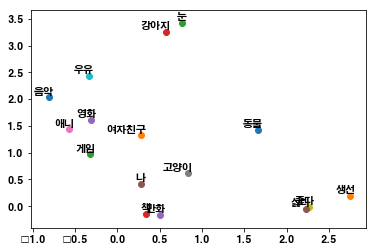

In [184]:
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

## [Word2Vec by implementing it in tensorflow](https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac)
- 참조 : https://github.com/harplife/TIL/blob/master/Data%20Science/Machine%20Learning/Word2Vec_tensorflow.ipynb


In [32]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [56]:
corpus_raw = "He is the king . THe king is royal . SHe is the royal queen"
corpus_raw = corpus_raw.lower()
print(corpus_raw)

words = []

for word in corpus_raw.split():
    if word != '.':
        words.append(word)

words = set(words)
print("words : {}".format(words))
raw_sents = corpus_raw.split('.')

sents = []
for sent in raw_sents:
    sents.append(sent.split())
    
print("sents : {}".format(sents))



he is the king . the king is royal . she is the royal queen
words : {'the', 'he', 'royal', 'queen', 'she', 'is', 'king'}
sents : [['he', 'is', 'the', 'king'], ['the', 'king', 'is', 'royal'], ['she', 'is', 'the', 'royal', 'queen']]


### Skip-Gram 모델
- 중심단어로 주변단어 예측
- 앞뒤로 window 사이즈로 문장 단어 하나씩 그 주변의 단어들과 짝을 만들 어줘 input data 만듬


In [57]:
data = []

WINDOW_SIZE = 2

# 각 문장에 나오는 단어들에서 단어들 하나씩
for sent in sents:
    # 그 단에에대해 enumerate
    for word_index, word in enumerate(sent):
        # 각 중심단어에 대한 n-gram 쌍을 만들어줌
        for nb_word in sent[max(word_index- WINDOW_SIZE,0) : min(word_index + WINDOW_SIZE, len(sent)) + 1]:
            if nb_word != word:
                data.append([word, nb_word])

In [58]:
# word (중심단어, 주변단어) 짝 
print(data)

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]


### 데이터 numbering
- 단어에 대한 인덱싱 처리

In [59]:
word2int = {}
int2word = {}

vocab_size = len(words)

for i, word in enumerate(words):
    word2int[word] = i
    int2word[i] = word
print(word2int)
print(int2word)

{'the': 0, 'he': 1, 'royal': 2, 'queen': 3, 'she': 4, 'is': 5, 'king': 6}
{0: 'the', 1: 'he', 2: 'royal', 3: 'queen', 4: 'she', 5: 'is', 6: 'king'}


### one-hot encoding
- 특정 요소만 1 나머지는 전부 0

#### look-up-table
- one-hot vector로 부터 특정 행(혹은 열)의 값만을 뽑아냄(참조)
- 이를 통해 one-hot vector의 특성을 내적하게되는 행렬에 지정해놓은 차원만큼에 그 one-hot vector의 특성을 나타낼 수 있음

In [66]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

# onep-hot 처리
x_train = []
y_train = []

# data는 각 문장에서 단어들의 주변단어를 윈도우크기에 맞춰 쌍으로 뽑은 것 
for data_word in data:
    # 중심단어에 해당하는 단어의 index를 뽑고 이를 통해 one-hot 처리
    x_train.append(to_one_hot(word2int[data_word[0]], vocab_size))
    # 주변단어 해당하는 단어의 index를 뽑고 이를 통해 one-hot 처리
    y_train.append(to_one_hot(word2int[data_word[1]], vocab_size))
# np array로 바꿔줌
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
    

In [75]:
print(len(data))
print(x_train.shape)
print(x_train[:3])

34
(34, 7)
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
(34, 7)


### 3-layer Neural Network

In [94]:
tf.reset_default_graph()

# input
# (None , 7)
X = tf.placeholder(tf.float32, shape=(None, vocab_size))
# (None , 7)
Y = tf.placeholder(tf.float32, shape=(None, vocab_size))

# hidden
# one-hot vector 차원 줄여주기위한 차원 수
EMBEDDING_DIM = 5

# (7,5)
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
# (5)
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM]))

# Hidden Representation
H = tf.add(tf.matmul(X, W1),b1)

# output
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))

# activation function(softmax)
prediction = tf.nn.softmax(tf.add(tf.matmul(H,W2),b2))


cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(prediction), reduction_indices=[1]))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cost)

epoch = 10000
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for step in range(epoch):
    _, cost_val = sess.run([train, cost], feed_dict = {X: x_train, Y: y_train})
    
    if step%1000 == 0:
        print("cost_val : {}".format(cost_val))

cost_val : 3.5645406246185303
cost_val : 1.3898719549179077
cost_val : 1.3316664695739746
cost_val : 1.3241262435913086
cost_val : 1.3220187425613403
cost_val : 1.3211928606033325
cost_val : 1.3208149671554565
cost_val : 1.3206267356872559
cost_val : 1.320528507232666
cost_val : 1.3204753398895264


In [98]:
# 7차원의 one hot vector에 대해서 =
# > 각 단어들에대한 특징벡터로 나타내기 위해서는 7X7
# 7X5차원의 단어들 특징벡터로  차원을 축소하며 특징을 갖고
# 거기에다가 기존의 one-hot vecotr는 단어간 연관성을 찾아볼 수 없었지만
# 단어간의 거리를 나타내는 단어들의 특징벡터로 값을 얻을 수 있게됨
print(sess.run(W1).shape)
print(sess.run(W1))

(7, 5)
[[-2.556347    1.6123743  -1.8784006   1.2896063  -1.6559213 ]
 [ 2.5315738   0.9115065   0.09868844 -0.6590302   1.1245557 ]
 [-0.9082902   3.4051232   1.3954      0.27228242 -0.7939709 ]
 [-1.4029421  -1.7345221  -0.28925392 -1.7250462   1.3250414 ]
 [ 2.2451978   1.1083224   0.5280316   1.0392879   0.7027283 ]
 [-1.8287591  -2.1388304  -0.6116653   1.6228342  -1.3408877 ]
 [-0.3985555   0.74965495 -0.11099403 -0.9881404   2.5304747 ]]


In [104]:
vectors = sess.run(W1 + b1)


### 근접 단어 찾기

#### Euclidean Distance (유클리드 거리)
- 피타고라스 정리를 기반으로 거리계산

In [106]:
# 유클리디안 거리 공식
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum(np.square(vec1-vec2)))
# 근접 단어 검색
def find_closest(word_index, vectors):
    min_dist = 10000
    min_index = -1
    
    # input vector
    query_vector = vectors[word_index]
    
    for index, vector in enumerate(vectors):
        # 적당히 너무 멀지않고(10000)
        # 전에 적용된 근접거리 보다 적고(?)
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [107]:
# 근접하 단어들
for w in words:
    print(w, int2word[ find_closest(word2int[w], vectors)])

the is
he she
royal the
queen king
she he
is the
king queen


### 그래프로 확인해보기

In [110]:
# 차원 줄여주는 TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors_2d = model.fit_transform(vectors)

# 벡터값 Normalize
normalize = preprocessing.Normalizer()
vecotrs_2d = normalize.fit_transform(vectors, '12')

### Matplotlib으로 plot

In [120]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
# fig, ax = plt.subplots()

for w in words:
    print("{}: ({},{})".format(w, vectors_2d[word2int[w]][0], vectors_2d[word2int[w]][1] ))    
    print( w, " => ",int2word[ find_closest( word2int[w], vectors_2d ) ] )    
    print()    
    ax.annotate(w,(vectors_2d[word2int[w]][0],vectors_2d[word2int[w]][1]) )
    
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
plt.show()

the: (164.78781127929688,-166.6956024169922)
the  =>  he

he: (-40.88252639770508,-203.68263244628906)
he  =>  the

royal: (100.71846008300781,189.54046630859375)
royal  =>  king

queen: (-104.95435333251953,152.54917907714844)
queen  =>  is

she: (235.58802795410156,29.91579818725586)
she  =>  king

is: (-175.75253295898438,-44.06285858154297)
is  =>  he

king: (29.918577194213867,-7.070892810821533)
king  =>  she



(-4, 4)